# Neural Process example implementation for Mixture Density Learning

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from typing import Callable, Sequence, Any
from functools import partial

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn

import optax
import jaxopt

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock

rng = jax.random.key(0)
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

cuda? [cuda(id=0)] NVIDIA GeForce GTX 1050


2024-05-26 20:32:02.095675: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# Test-configuration
dataset_size = 128
test_resolution = 512

In [3]:
# Train-configuration
num_posterior_mc = 1  # number of latents to sample from p(Z | X, Y)
batch_size = 128  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 32
num_context_samples = 64

## Define Training Distribution/ Data-Generation

In [58]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=2, period=1.5, period_range=.8)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)
f5 = Shift(Fourier(n=2, amplitude=0.5, period=1, period_range=0.2), y_shift=0.0, y_shift_range=3.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

rng = jax.random.key(0)

In [59]:
### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys

<Axes: xlabel='None', ylabel='None'>

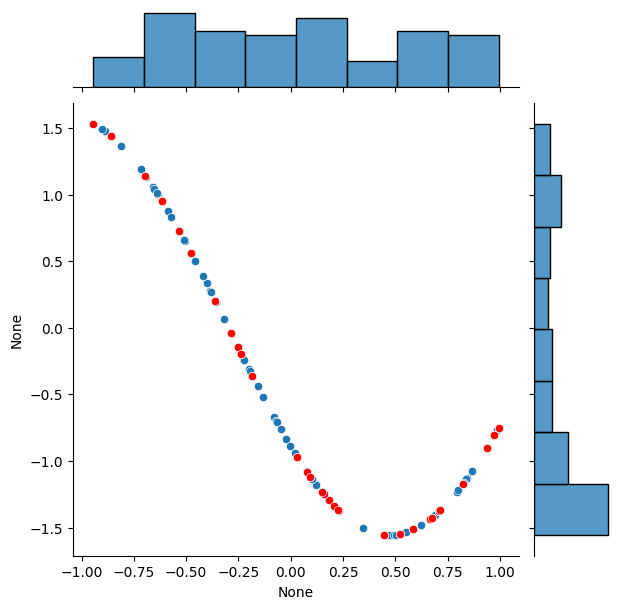

In [60]:
# Specify which function-prior to learn
# data_sampler = partial(
#     joint, 
#     Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
#     partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
# )
data_sampler = partial(
    joint, 
    f5, 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

rng, key = jax.random.split(rng)
xs, ys = data_sampler(key)

X, x_target = jnp.split(xs, indices_or_sections=(num_context_samples, ))
y, y_target = jnp.split(ys, indices_or_sections=(num_context_samples, ))

sns.jointplot(x=xs, y=ys)
sns.scatterplot(x=x_target, y=y_target, color='red')  # prediction targets

## Define Test-Case

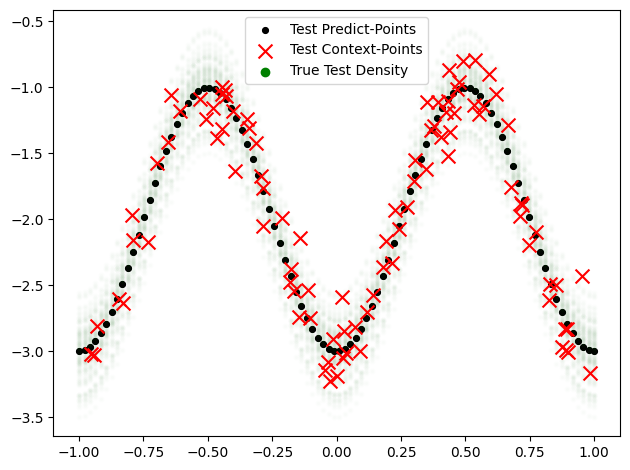

In [43]:

# def f(
#     key: flax.typing.PRNGKey, 
#     x: jax.Array, 
#     noise_scale: float = 0.2, 
#     mixture_prob: float = 0.5, 
#     corrupt: bool = True
# ):
#     key_noise, key_mixture = jax.random.split(key)
    
#     noise = jax.random.normal(key, x.shape) * noise_scale
#     choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

#     # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
#     return choice * (-2-jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2+jnp.cos(2 * jnp.pi * x)) + corrupt * noise


def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    
    noise = jax.random.normal(key, x.shape) * noise_scale

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return(-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise



rng, key_data, key_test, key_x = jax.random.split(rng, 4)

keys_data = jax.random.split(key_data, (96,))
keys_test = jax.random.split(key_test, (96,))


xs = jax.random.uniform(key_x, (96,)) * 2 - 1
ys = jax.vmap(f)(keys_data, xs)

x_test = jnp.linspace(-1, 1, 96)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)

# Repeat the random keys for each x-point. Roughly gives an idea of the spread
y_test_samples = jax.vmap(jax.vmap(
    partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(
    jnp.broadcast_to(x_test, y_test_samples.shape).T, 
    y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01,
)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')

plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:

rng , key_data , key_test, key_x = jax.random.split(rng, 4)

xs = jax.random.uniform(key_x, (96,)) * 2 - 1
 
print(xs[..., None].shape)

(96, 1)


# Define the Model

In [9]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

/tmp/ipykernel_20799/566903709.py:31: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


### Test-predictions at init

In [12]:
# means, stds = model.apply(
#     params, 
#     xs[:, None], ys[:, None], x_test[:, None], 
#     k=15,
#     rngs={'default': jax.random.key(0)}
# )

print(xs[:, None].shape, ys[:, None].shape, x_test[:128, None].shape)
means, stds = model.apply(
    params, 
    xs[:, None], ys[:, None], x_test[:128, None], 
    k=1,
    rngs={'default': jax.random.key(0)}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

(128, 1) (128, 1) (128, 1)
prediction-shape (128, 1, 1) (128, 1, 1)


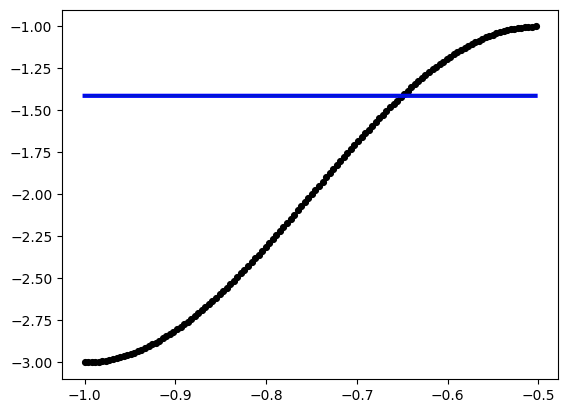

In [14]:
# Example predictions at init
plt.plot(x_test[:128], means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean

for i in range(means.shape[1]):
    plt.plot(x_test[:128], means[:, i], color='green', alpha=0.2)  # Mixture-components

plt.scatter(x_test[:128], y_test[:128], c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')

# Dummy Optimization/ Amortization procedure

In [11]:
# Define how the model loss should be computed

def posterior_loss(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )
    
    return -elbos.mean()


def posterior_loss_filtered(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )

    # Mask out all samples with higher data-likelihood than the worst 40%
    q40 = jnp.percentile(elbos, 40)
    mask = elbos <= q40
    
    return -(elbos * mask / mask.sum()).sum()


In [21]:
@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState, 
    random_key: flax.typing.PRNGKey
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    # value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, random_key)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


In [22]:
def body(carry, x):
    params, opt_state, key = carry

    key_carry, key_step = jax.random.split(key)
    params, opt_state, value = step(params, opt_state, key_step)

    return (params, opt_state, key_carry), value


@partial(jax.jit, static_argnums=3)
def scan_train(params, opt_state, key, num: int):
    
    last, out = jax.lax.scan(body, (params, opt_state, key), xs=None, length=num)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [23]:
scan_chunk = 100

# Initialize the Optimization.
rng, key = jax.random.split(rng)

last_key = key
print(last_key)

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10_000 // scan_chunk, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key, scan_chunk)

    losses.append(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params
losses = jnp.asarray(losses).ravel()

Array((), dtype=key<fry>) overlaying:
[1287589830 3556875206]


Optimizing params. Loss: -0.7558: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


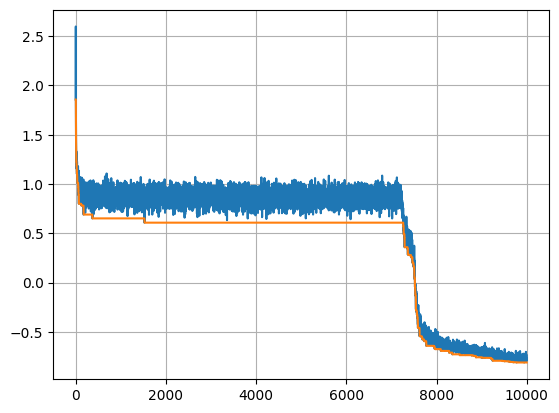

In [15]:
losses = jnp.asarray(losses).ravel()
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

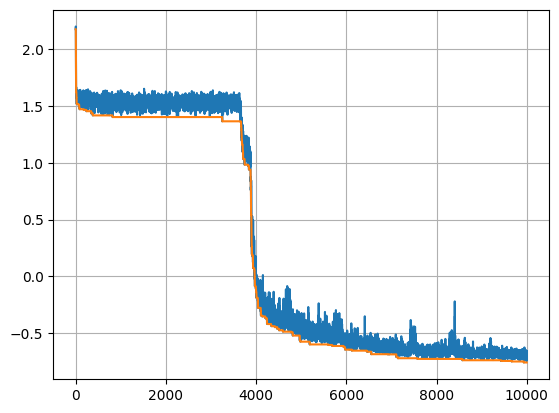

In [24]:
# Using q40 filtering

plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

# Test-predictions after training

In [16]:
rng, test_key = jax.random.split(rng)
print(test_key)

Array((), dtype=key<fry>) overlaying:
[2209151688  567477580]


In [25]:
# Test predictions on functions from the training-distribution
key_data, key_model = jax.random.split(test_key)

x_train, y_train = data_sampler(test_key)
x_train, y_train = x_train[..., None], y_train[..., None]

# Split into context- and target-points.
X, x_predict_train = jnp.split(x_train, indices_or_sections=(num_context_samples, ))
y, y_predict_train = jnp.split(y_train, indices_or_sections=(num_context_samples, ))

# Compute ELBO over batch of datasets
# means, stds = model.apply(
#     params, 
#     X, y, x_test[..., None],
#     k=10,
#     rngs={'default': jax.random.key(0)}
# )
means, stds = model.apply(
    params, 
    X, y, x_test[..., None],
    k=1,
    rngs={'default': key_model}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (512, 1, 1) (512, 1, 1)


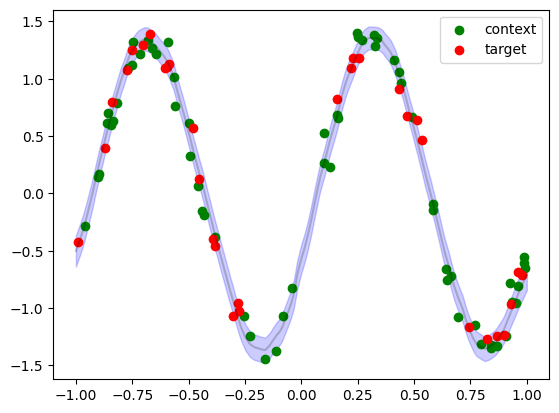

In [18]:
# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

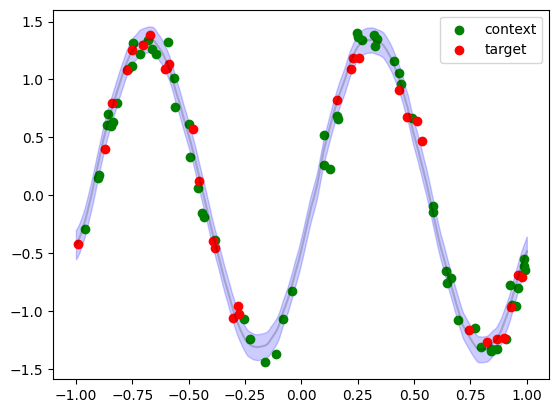

In [26]:
# Using q40 filtering

# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

In [27]:
# Test predictions on our test-function
means, stds = model.apply(
    params, 
    xs[:, None], ys[:, None], x_test[:, None], 
    k=1,
    rngs={'default': key_model}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (512, 1, 1) (512, 1, 1)


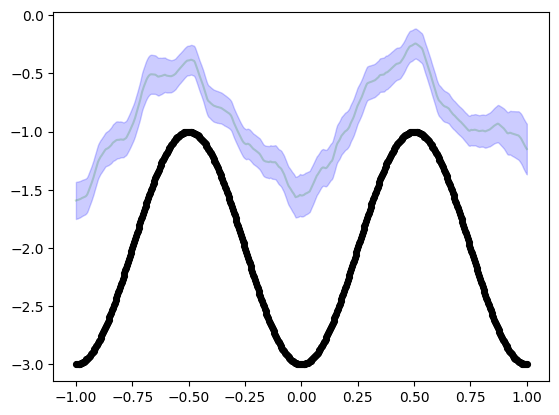

In [20]:
# Example predictions at init
# plt.plot(x_test, means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='green', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')

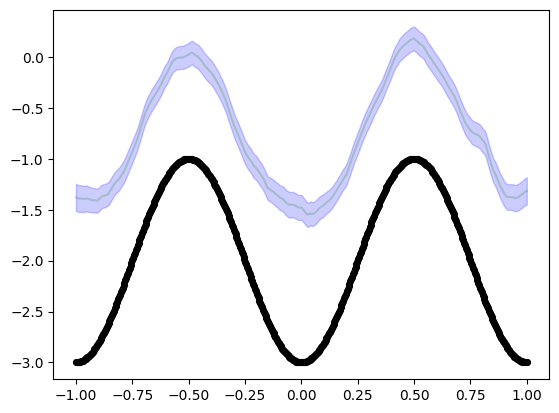

In [28]:
# Using q40 filtering

# Example predictions at init
# plt.plot(x_test, means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='green', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')